In [1]:
import tensorflow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [3]:
df_test = pd.read_feather('test_normalized_data.fth')

- Para verificar que columnas tiene originalmente tests. Por ejemplo, como es de esperar, la columna customers no es dato y podría intentar estimarse tambien
- Es bastante discutible usar el clima y temperatura (Se puede usar el forecast si es en el futuro
- En un caso real no parece sensato usar google trend

In [4]:
df_test.columns

Index(['index', 'Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State', 'file', 'week', 'trend',
       'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE', 'trend_DE',
       'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'CloudCove

In [5]:
df = pd.read_feather('train_normalized_data.fth')

In [6]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw' ] #,'StateHoliday_fw', 'StateHoliday_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw'

In [7]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [8]:
DataFrameSummary(df[cat_vars]).summary().loc[['uniques', 'types']]

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw
uniques,1115,7,3,12,31,4,25,26,4,3,4,21,8,12,52,22,6,6
types,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric


In [9]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [10]:
uniques

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw
uniques,1115,7,3,12,31,4,25,26,4,3,4,21,8,12,52,22,6,6


# Asignación de dimensión de embeddings

In [11]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 4, 'Year': 2, 'Month': 6,
'Day': 10, 'StateHoliday': 3, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 2, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_fw': 1,
'StateHoliday_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

## Ejemplo con DayOfWeek, store y CompetitionDistance

In [12]:
uniques['DayOfWeek'][0]

7

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Dense, Concatenate

In [14]:
day_of_week_input = Input(shape=(1,), name="day_of_week_input")
store_input = Input(shape=(1,), name="store_input")
# Por ser continua competition_distance no necesita embeddings
competition_distance_input = Input(shape=(1,), name="competition_distance_input")

day_of_week_Embedd_out = Embedding(uniques['DayOfWeek'][0], cat_var_dict['DayOfWeek'], name="day_of_week_Embedd")(day_of_week_input)
store_Embedd_out = Embedding(uniques['Store'][0], cat_var_dict['Store'], name="store_Embedd")(store_input)

In [15]:
print(f'Entradas: {day_of_week_input.shape}, {store_input.shape}')
print(f'Salidas: {day_of_week_Embedd_out.shape}, {store_Embedd_out.shape}')

Entradas: (None, 1), (None, 1)
Salidas: (None, 1, 4), (None, 1, 50)


In [16]:
day_of_week_Embedd_flat = Flatten(name="day_of_week_flat")(day_of_week_Embedd_out)
store_Embedd_flat = Flatten(name="store_flat")(store_Embedd_out)

In [17]:
merged = Concatenate(name='All_Concatenate')([day_of_week_Embedd_flat, store_Embedd_flat, competition_distance_input])

In [18]:
x = Dense(1000, activation='relu')(merged)
x = Dense(500, activation='relu')(x)
output = Dense(1, activation='linear')(x)

In [19]:
model = Model([day_of_week_input, store_input, competition_distance_input], output)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 day_of_week_input (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 store_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 day_of_week_Embedd (Embedding)  (None, 1, 4)        28          ['day_of_week_input[0][0]']      
                                                                                                  
 store_Embedd (Embedding)       (None, 1, 50)        55750       ['store_input[0][0]']            
                                                                                              

In [21]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]

In [22]:
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


In [23]:
df_train[['DayOfWeek', 'Store', 'CompetitionDistance']].values.shape

(814150, 3)

In [24]:
X_train = np.hsplit(df_train[['DayOfWeek', 'Store', 'CompetitionDistance']].values, 3)
X_val = np.hsplit(df_val[['DayOfWeek', 'Store', 'CompetitionDistance']].values, 3)

In [25]:
len(X_train[2])

814150

In [26]:
# Normalización
y_mean = df_train['Sales'].mean()
y_std = df_train['Sales'].std()

# Escala logaritmica
# max_log_y = np.max(np.log(df['Sales']))
# y_train = np.log(df['Sales'])/max_log_y

In [27]:
y_train = (df_train['Sales'].values - y_mean)/y_std
y_val = (df_val['Sales'].values - y_mean)/y_std

In [28]:
model.compile(optimizer=Adam(lr=0.001), metrics=['mse'], loss='mse')

C:\Users\Franco\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=1, batch_size=256)

3181/3181 [==============================] - 32s 10ms/step - loss: 0.3355 - mse: 0.3355 - val_loss: 0.2416 - val_mse: 0.2416


# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [30]:
y_pred_norm = model.predict(X_val, verbose=1)
y_pred = y_pred_norm*y_std + y_mean
# y_pred = np.exp(model.predict(X_train)*max_log_y)

944/944 [==============================] - 2s 2ms/step


In [31]:
def root_mean_squared_error_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_pred - y_true)), axis=-1))

def rmspe_np(y_true, y_pred):
    MSEP_ = ((y_true - y_pred)/y_true)**2
    return np.sqrt(MSEP_.mean())

In [32]:
rmspe_np(df_val['Sales'].values, y_pred.reshape(-1))

0.2245943567527133

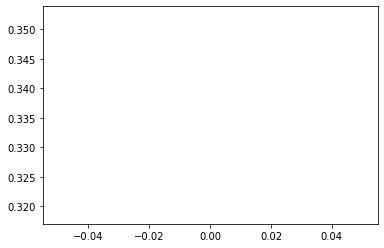

In [33]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.show()